In [1]:
# importing packages and modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
from analysis_utils import *
import dynamic_glmhmm
from scipy.stats import multivariate_normal, norm
sns.set_context("talk")

# Generating dataset


In [2]:
# setting hyperparameters
S = 20 # sessions
T = 500 # trials per session
N = T * S # total data points
C = 2 # classes
K = 2 # states
D = 2 # features (sensory & bias)
truepi = np.ones((K))/K

In [3]:
# # Generate True Weights and Session Start Indices

# ourW = np.zeros((S,K,D))
# ourW[:,0,1] = np.linspace(0,2,S) # state 1 sensory (increasing)
# ourW[:,0,0] = np.linspace(-1,0,S) # state 1 bias (decreasing)
# ourW[:,1,1] = 0 # state 2 sensory (flat 0)
# ourW[:,1,0] = 1 # state 2 bias (flat 1)
# trueW = np.zeros((N,K,D,C))
# # change weight format to have session*trials points
# sessInd = []
# for sess in range(0,S):
#     sessInd.append(sess*T)
#     for t in range(0,T):
#         trueW[sess*T+t,:,:,1] = ourW[sess,:,:]
# sessInd.append(N)

# print(trueW.shape)
# fig, axes = plt.subplots(2,1, figsize=(10,6), sharex=True)
# plotting_weights_per_feature(trueW, sessInd=sessInd, axes=axes, yLim=[[-3,3],[-3,3]], trueW=None, labels=['bias', 'sensory'])

In [4]:
# # Generate True Transition Matrix
# ourP = np.zeros((2,2))
# ourP[0,0]=0.97
# ourP[0,1]=0.03
# ourP[1,0]=.09
# ourP[1,1]=.91
# print("Global Transition Matrix P")
# print(ourP)

# alpha = 200
# trueP = np.zeros((N,K,K))
# for sess in range(0,S):
#     a = np.random.dirichlet(alpha * ourP[0])
#     b = np.random.dirichlet(alpha * ourP[1])
#     trueP[sess*T:(sess+1)*T,0,:] = a
#     trueP[sess*T:(sess+1)*T,1,:] = b

# fig, axes = plt.subplots(1, figsize = (8,6), dpi=400)
# plotting_self_transition_probabilities(trueP, sessInd, axes, sortedStateInd=None)
# axes.set_ylim(0,1)

In [5]:
# # generate data
# dGLMHMM = dynamic_glmhmm.dynamic_GLMHMM(N, K, D, C)
# trainX, trainY, z = dGLMHMM.simulate_data(trueW, trueP, truepi, sessInd)

# # save dataset
# np.savez('../data_demo/dataset_two_state_simulated', trainX=trainX, trainY=trainY, trueW = trueW, trueP=trueP, sessInd=sessInd)

# Loading dataset

(0.0, 1.0)

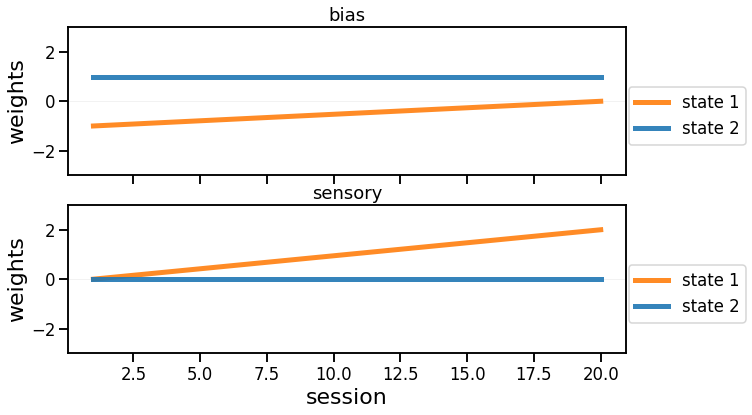

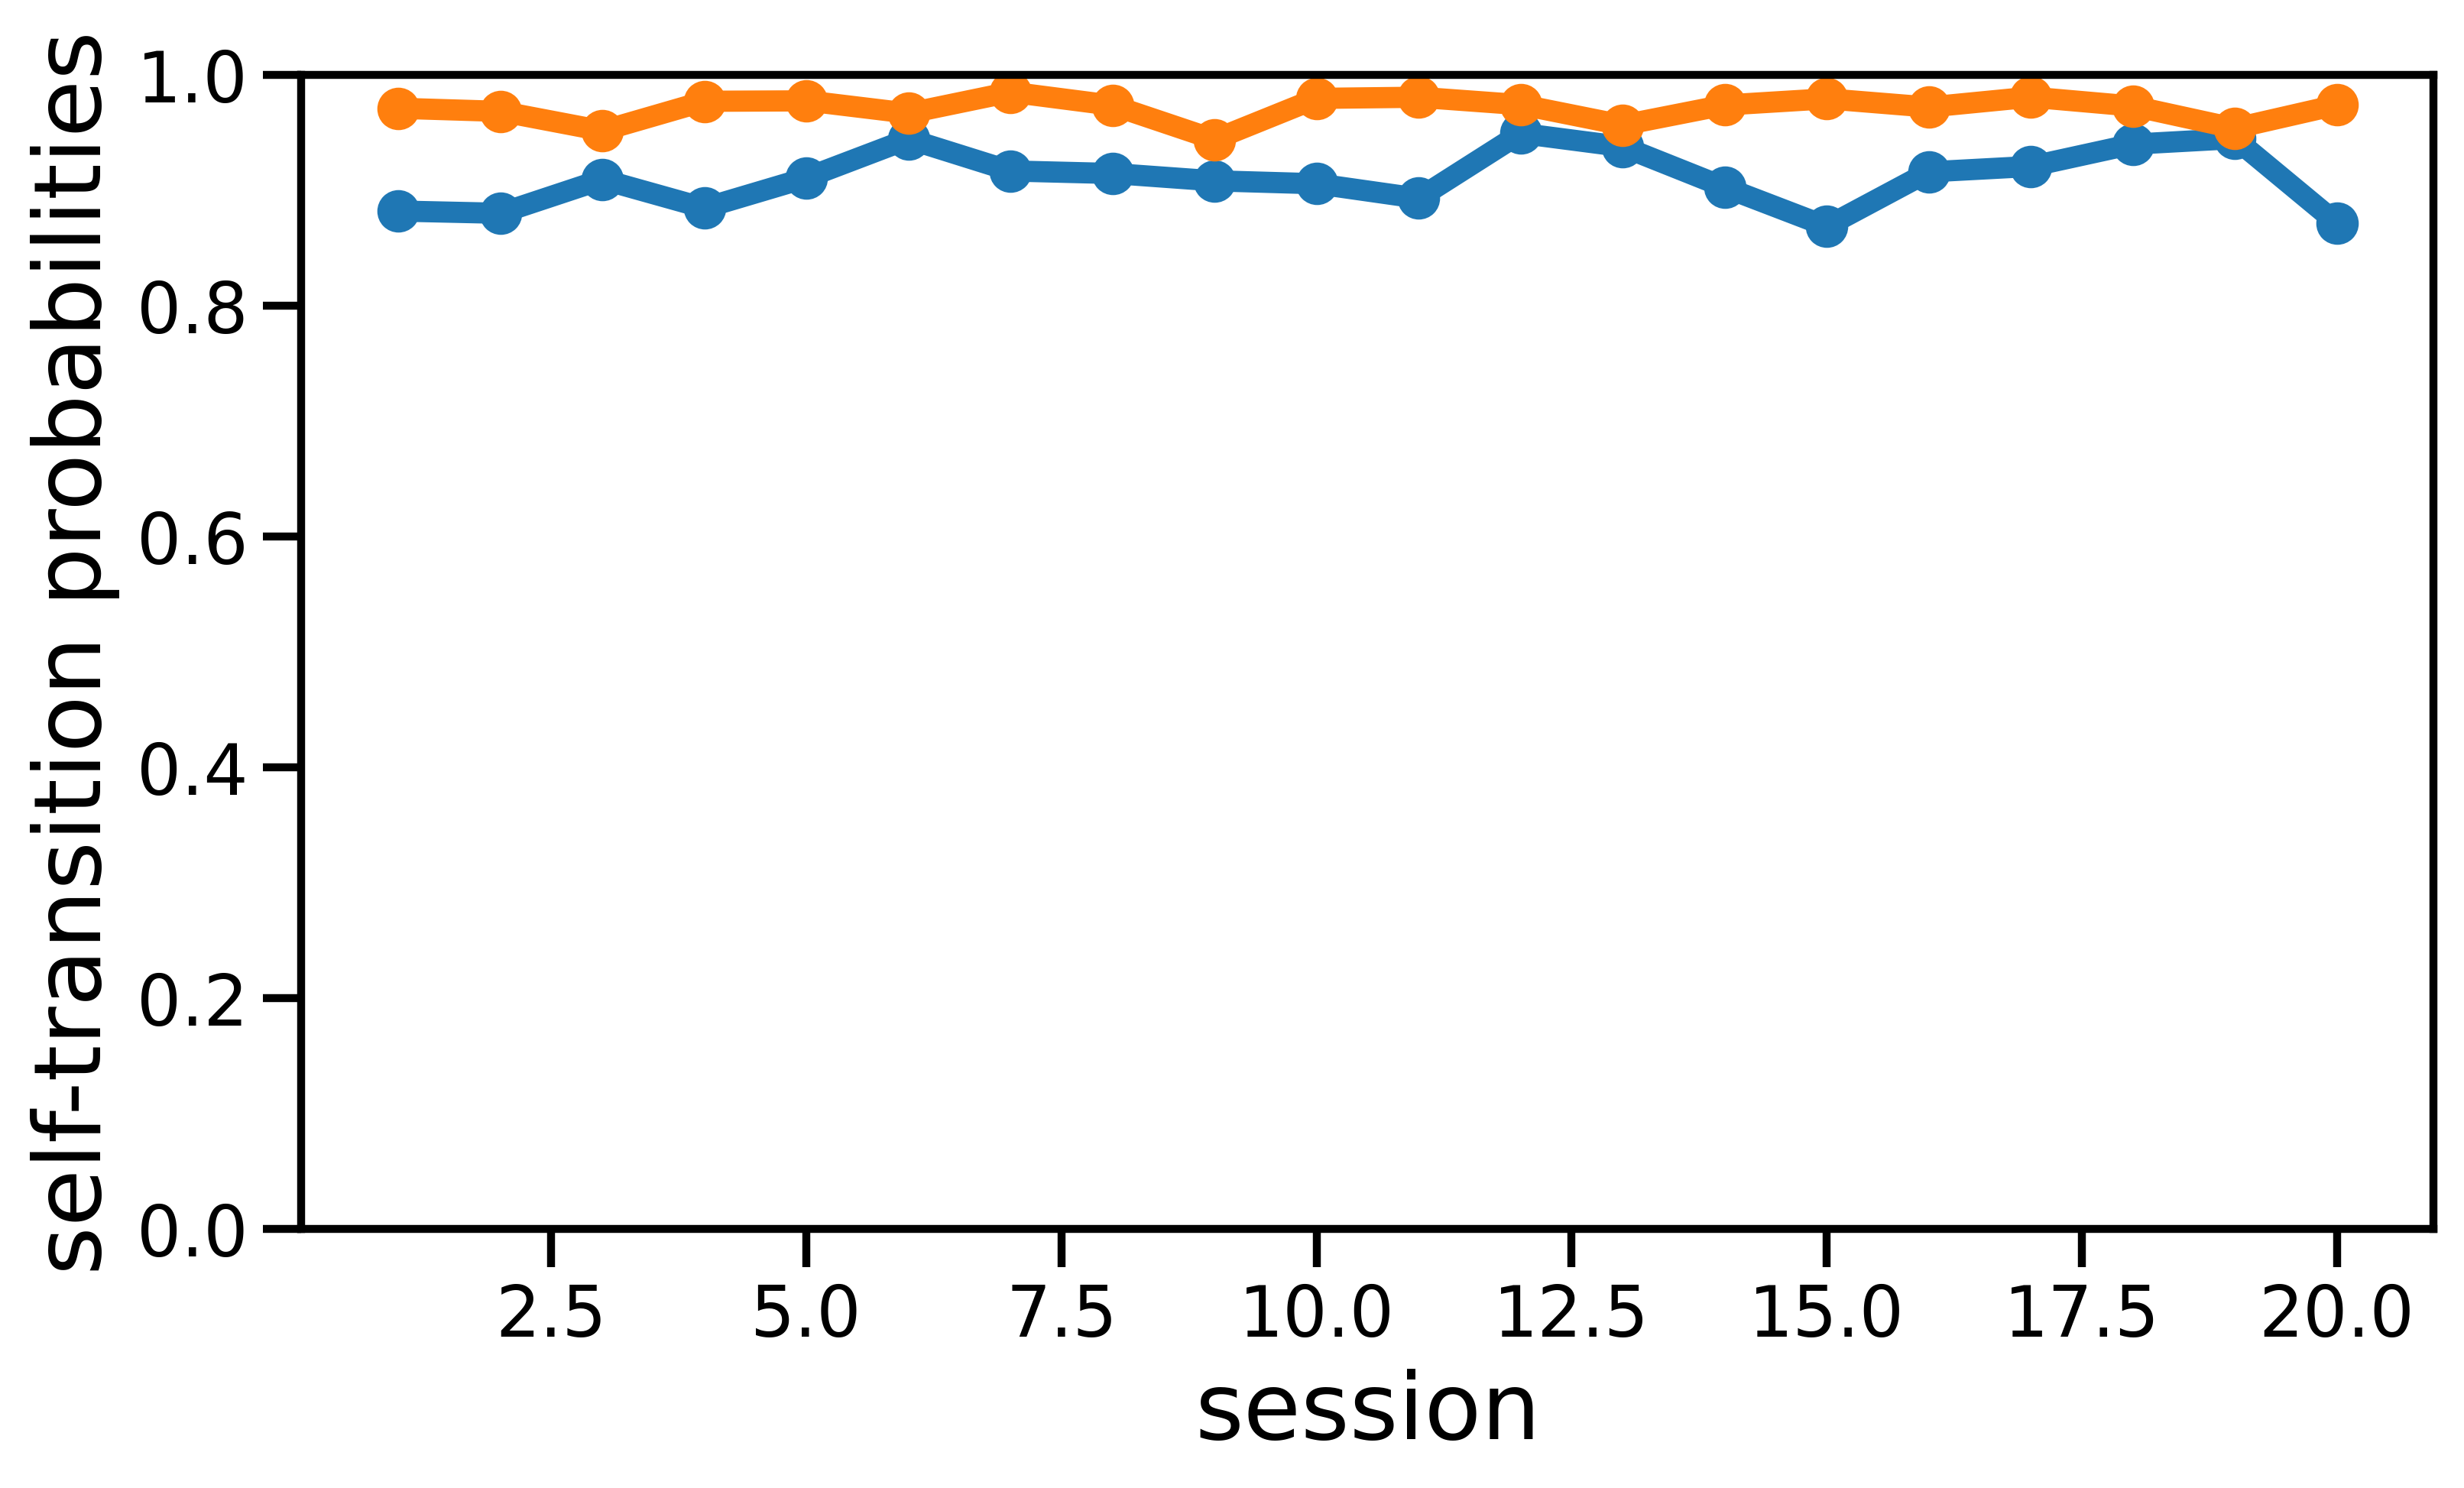

In [11]:
# load dataset
dataset = np.load('../data_demo/dataset_two_state_simulated.npz')
trueW = dataset['trueW']
trueP = dataset['trueP']
sessInd = dataset['sessInd']
trainX = dataset['trainX']
trainY = dataset['trainY']

dGLMHMM = dynamic_glmhmm.dynamic_GLMHMM(N, K, D, C)

# plot true parameters
fig, axes = plt.subplots(2,1, figsize=(10,6), sharex=True)
plotting_weights_per_feature(trueW, sessInd=sessInd, axes=axes, yLim=[[-3,3],[-3,3]], trueW=None, labels=['bias', 'sensory'])

fig, axes = plt.subplots(1, figsize = (9,5), dpi=400)
plotting_self_transition_probabilities(trueP, sessInd, axes, sortedStateInd=None)
axes.set_ylim(0,1)


# Fit standard model first (static weights and static transition matrix)

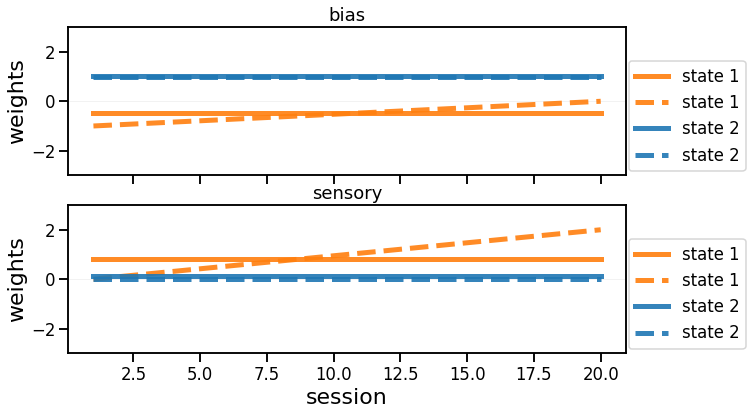

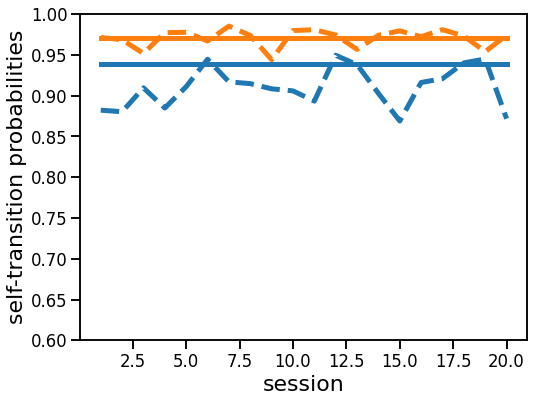

In [7]:
model_type = 'standard'
initP, initpi, initW = dGLMHMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)], model_type=model_type) 
present = np.ones((N))
irrelevantSigma = np.ones((K,D))
standardP, standardpi, standardW, _ = dGLMHMM.fit(trainX, trainY,  present, initP=initP, initpi=initpi, initW=initW, sigma=irrelevantSigma, sessInd=sessInd, maxIter=100, tol=1e-4, priorDirP=[10,1], model_type=model_type) # fit the model

# check if state identities were switched (by convention, state 1 has highest stimulus weights)
sortedStateInd = get_states_order(standardW, sessInd)

# plot best fitted static parameters (standard model)
fig, axes = plt.subplots(2,1, figsize=(10,6), sharex=True)
plotting_weights_per_feature(standardW, sessInd=sessInd, axes=axes, yLim=[[-3,3],[-3,3]], sortedStateInd=sortedStateInd, trueW=trueW, labels=['bias', 'sensory'])
fig, axes = plt.subplots(figsize=(8,6))
plotting_self_transition_probabilities(standardP, sessInd, axes, sortedStateInd=sortedStateInd, linestyle='-')
plotting_self_transition_probabilities(trueP, sessInd, axes, sortedStateInd=None, linestyle='--')

# Fit partial model next (dynamic weights and static transition matrix)

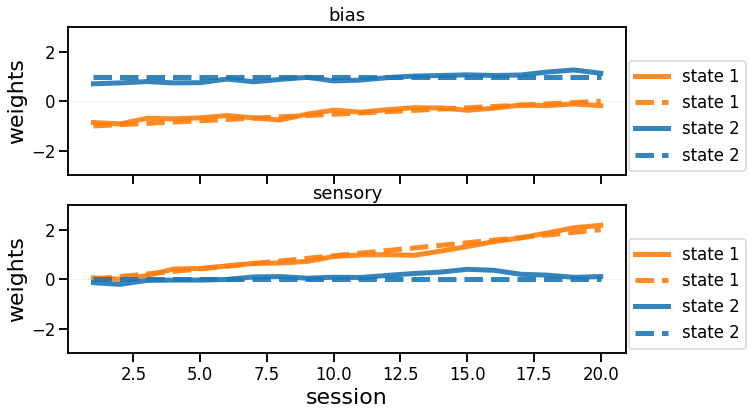

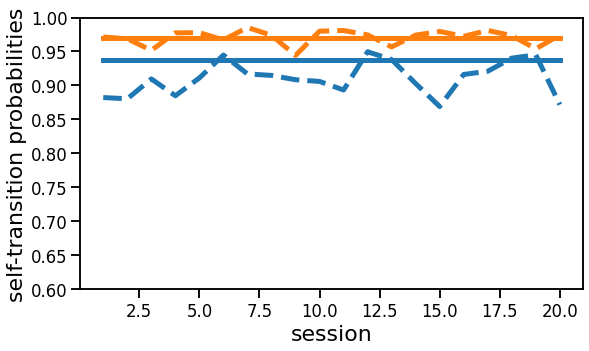

In [8]:
model_type = 'partial'
present = np.ones((N))
sigma = np.ones((K,D)) * 0.2
partialP, partialpi, partialW, _ = dGLMHMM.fit(trainX, trainY,  present, initP=standardP, initpi=standardpi, initW=standardW, sigma=sigma, sessInd=sessInd, maxIter=100, tol=1e-4, priorDirP=[10,1], model_type=model_type) # fit the model

# plot best fitted parameters from partial model
fig, axes = plt.subplots(2,1, figsize=(10,6), sharex=True)
plotting_weights_per_feature(partialW, sessInd=sessInd, sortedStateInd=sortedStateInd, axes=axes, yLim=[[-3,3],[-3,3]], trueW=trueW, labels=['bias', 'sensory'])
fig, axes = plt.subplots(figsize=(9,5))
plotting_self_transition_probabilities(partialP, sessInd, axes, sortedStateInd=sortedStateInd, linestyle='-')
plotting_self_transition_probabilities(trueP, sessInd, axes, sortedStateInd=None, linestyle='--')

# Fit dynamic model last (dynamic weights and dynamic transition matrix)

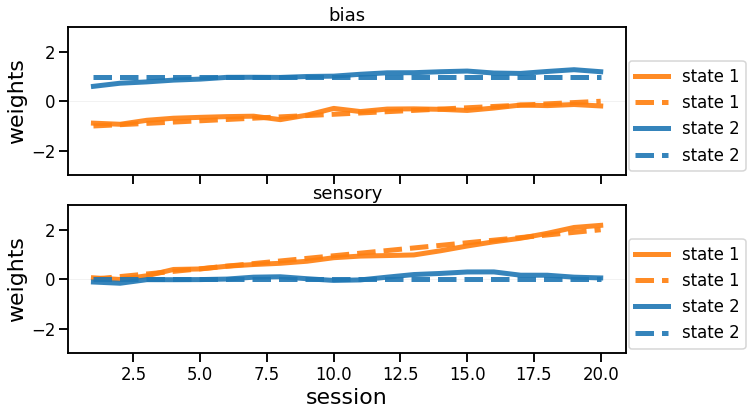

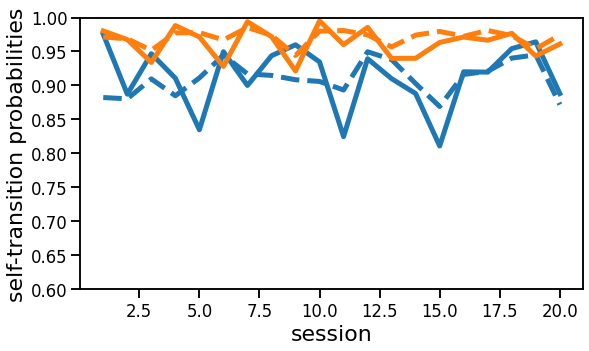

In [9]:
model_type = 'dynamic'
present = np.ones((N))
sigma = np.ones((K,D)) * 0.2
dynamicP, dynamicpi, dynamicW, _ = dGLMHMM.fit(trainX, trainY,  present, initP=partialP, initpi=partialpi, initW=partialW, sigma=sigma, sessInd=sessInd, maxIter=100, tol=1e-4, A=partialP[0], priorDirP=None, model_type=model_type) # fit the model

# plot the best fitted dynamic parameters
fig, axes = plt.subplots(2,1, figsize=(10,6), sharex=True)
plotting_weights_per_feature(dynamicW, sessInd=sessInd, axes=axes, yLim=[[-3,3],[-3,3]], sortedStateInd=sortedStateInd, trueW=trueW, labels=['bias', 'sensory'])
fig, axes = plt.subplots(figsize=(9,5))
plotting_self_transition_probabilities(dynamicP, sessInd, axes, sortedStateInd=sortedStateInd, linestyle='-')
plotting_self_transition_probabilities(trueP, sessInd, axes, sortedStateInd=None, linestyle='--')

# Post-fitting analysis

Text(0.5, 1.0, 'Per-state accuracy')

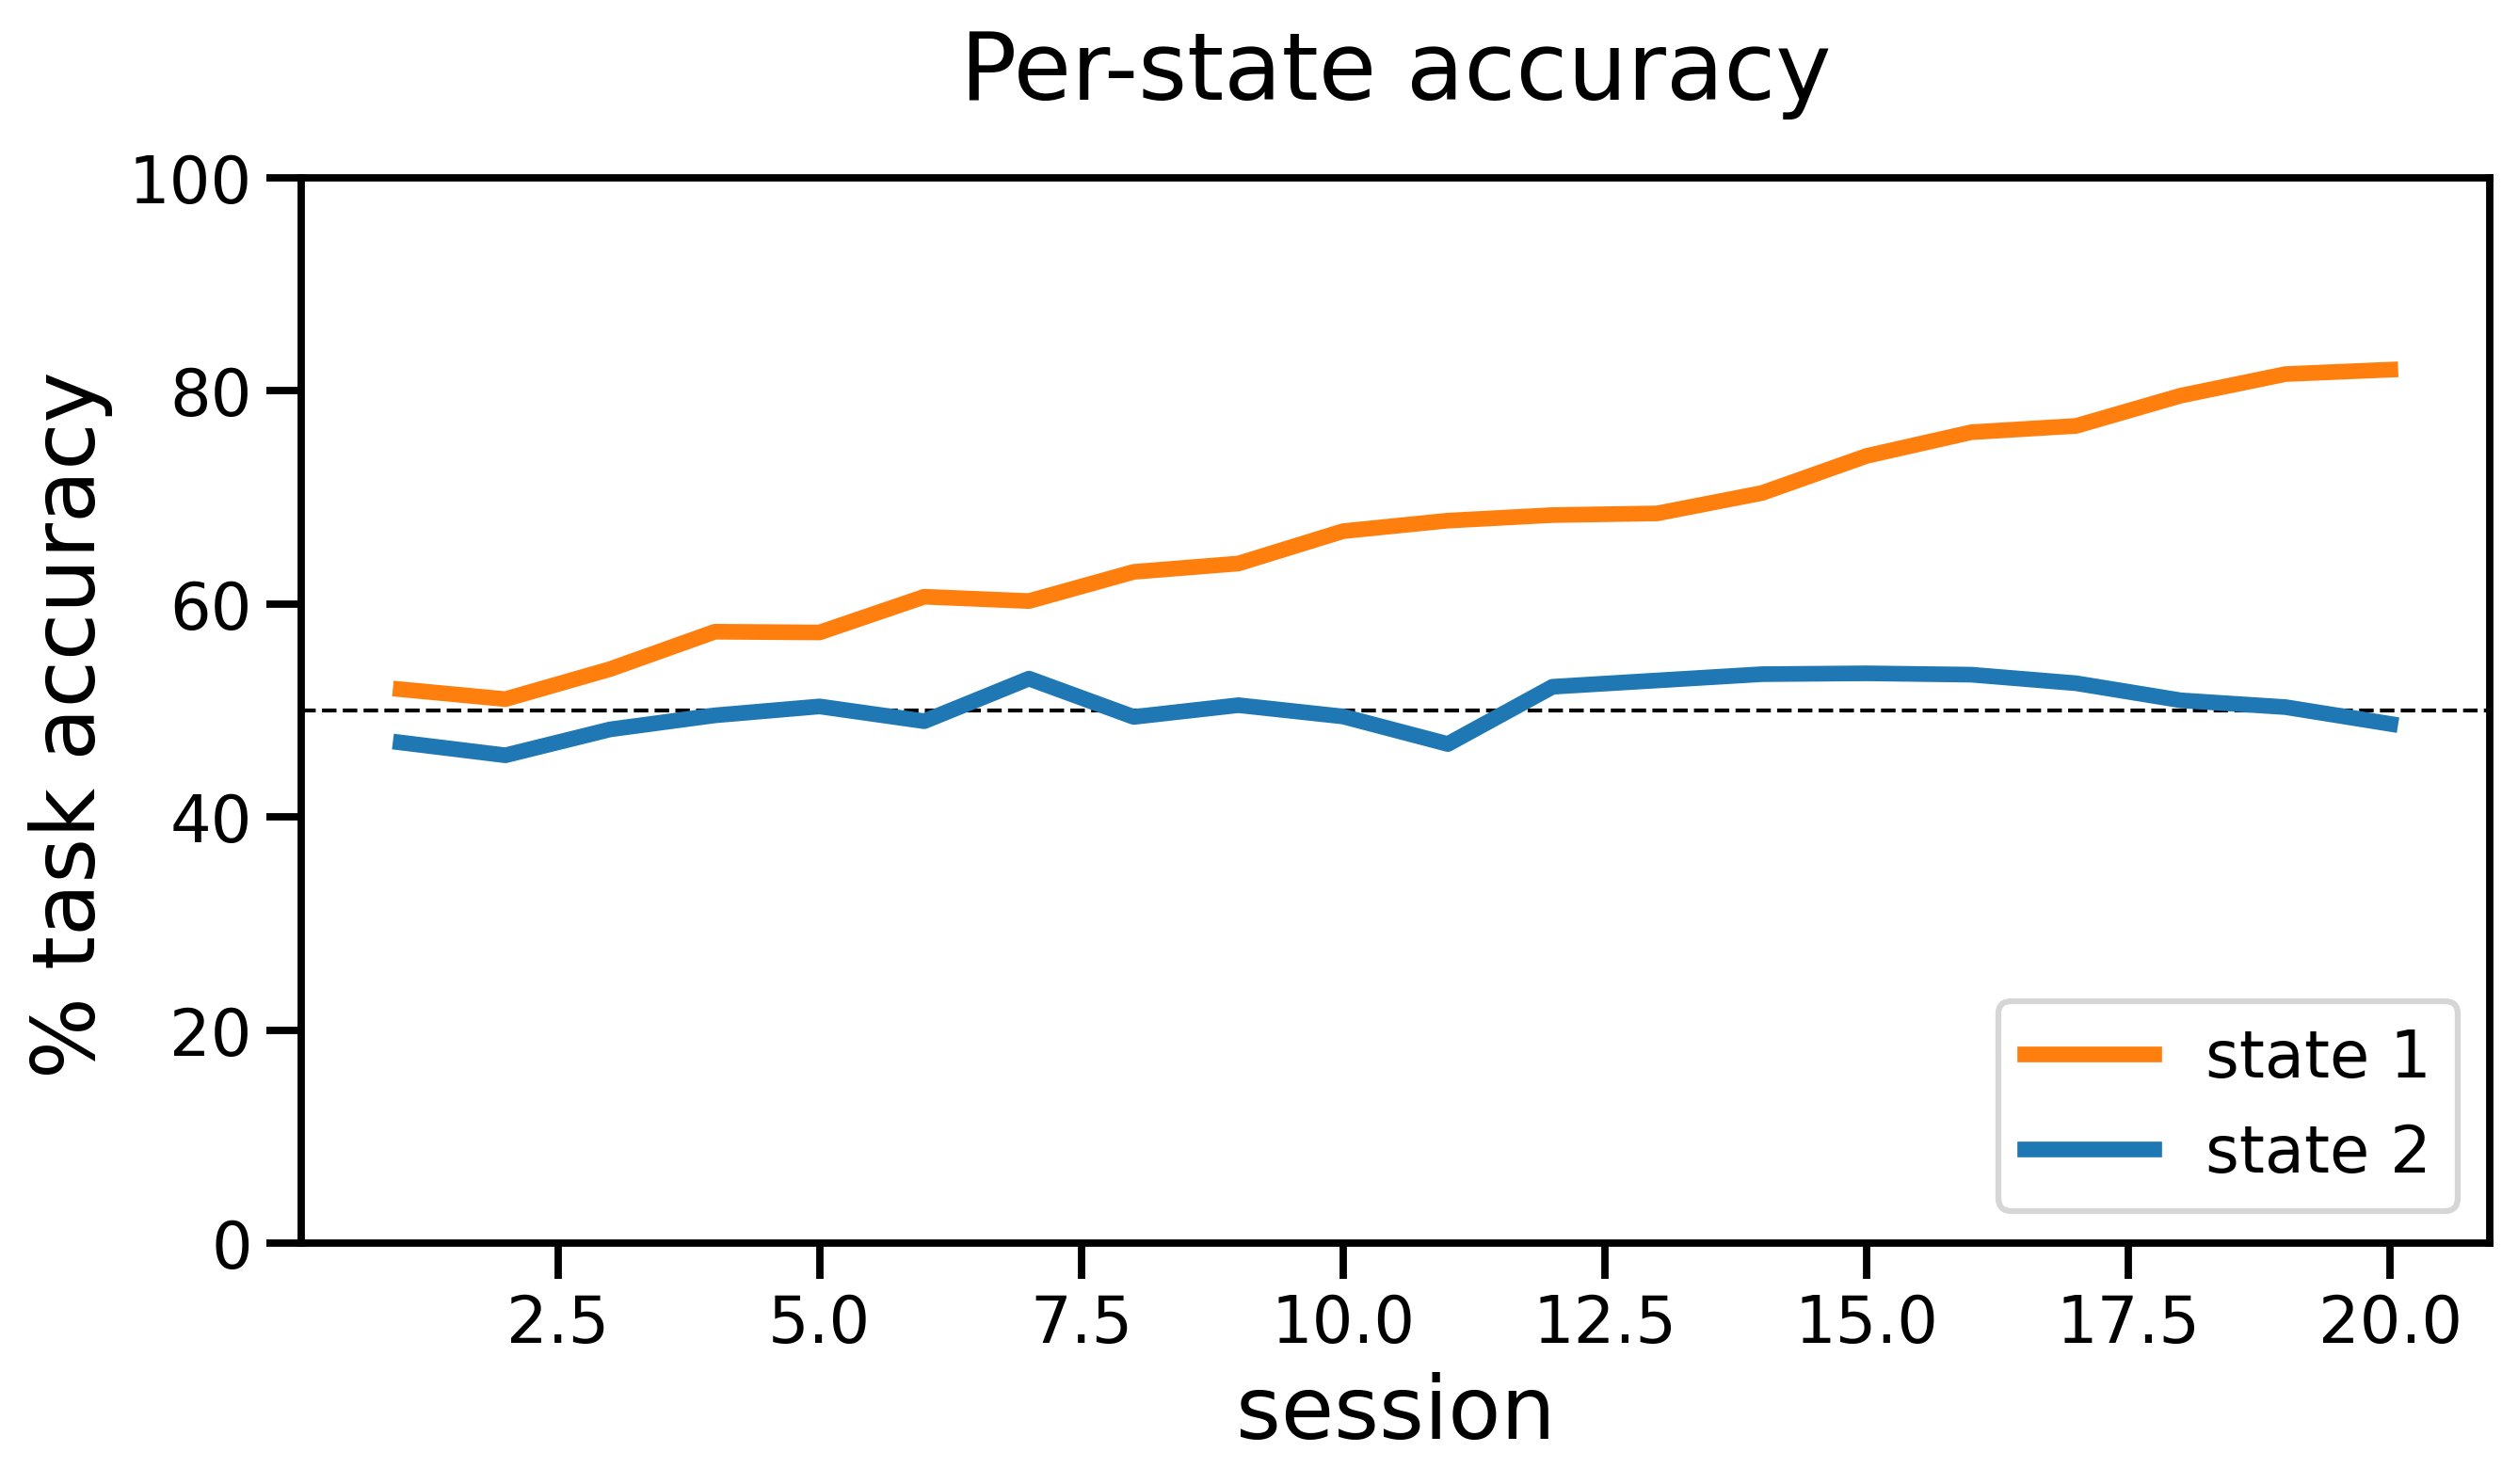

In [12]:
correctSide = (trainX[:,1] > 0).astype(int) # get correct side for each trial
presentAll = np.ones((N)) # using all data points for computing likelihood of being in each state

# compute state and choice probabilities based on fitted parameters
gamma = dGLMHMM.posterior_likelihood_of_each_state(dynamicP, dynamicpi, dynamicW, trainX, trainY, presentAll, sessInd)
phi = dGLMHMM.observation_probability(trainX, dynamicW)

# copmuting task accuracy in each state across sessions
p_correct, p_correct_states, p_correct_sessions, p_correct_states_sessions = accuracy_states_sessions(gamma, phi, trainY, correctSide, sessInd)

# plotting per-state task accuracy
fig, axes = plt.subplots(1, figsize = (10,5), sharex=True, dpi=300) 
axes.axhline(50, color='black', linestyle='dashed', linewidth=1)
plotSess = 20
for k in range(0,K):
    axes.plot(range(1,plotSess+1), p_correct_states_sessions[:plotSess,sortedStateInd[k]], color=colorsStates[k], linewidth=4, label=f'state {k+1}')
axes.set_ylim(0,100)
axes.set_ylabel('% task accuracy ', size=22)
axes.set_xlabel('session', size=22)
legend = axes.legend(loc='lower right')
axes.set_title('Per-state accuracy', size=24, pad=20)
